# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

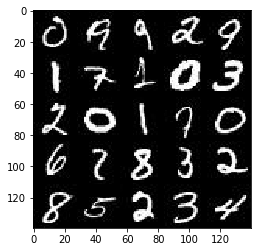

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

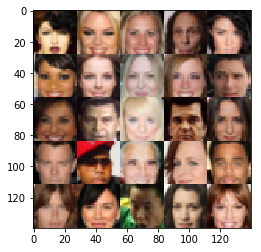

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2 # factor for leaky ReLu
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        bn_1 = tf.layers.batch_normalization(x_1, training=True)
        relu_1 = tf.maximum(alpha * bn_1, bn_1)
        
        x_2 = tf.layers.conv2d(relu_1, 128, 5, strides=2, padding='same')
        bn_2 = tf.layers.batch_normalization(x_2, training=True)
        relu_2 = tf.maximum(alpha * bn_2, bn_2)
        
        x_3 = tf.layers.conv2d(relu_2, 256, 5, strides=2, padding='valid')
        bn_3 = tf.layers.batch_normalization(x_3, training=True)
        relu_3 = tf.maximum(alpha * bn_3, bn_3)

        # Flatten it
        flat = tf.reshape(relu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2 # factor for leaky ReLu
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*512)
        # Layer-out: 2048
        
        # Reshape it to start the convolutional stack
        x_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        bn_2 = tf.layers.batch_normalization(x_2, training=is_train)
        relu_2 = tf.maximum(alpha * bn_2, bn_2)
        # Layer-out: 2x2x512
        
        x_3 = tf.layers.conv2d_transpose(relu_2, 256, 5, strides=2, padding='valid')
        bn_3 = tf.layers.batch_normalization(x_3, training=is_train)
        relu_3 = tf.maximum(alpha * bn_3, bn_3)
        # Layer-out: 7x7x256

        x_4 = tf.layers.conv2d_transpose(relu_3, 128, 5, strides=2, padding='same')
        bn_4 = tf.layers.batch_normalization(x_4, training=is_train)
        relu_4 = tf.maximum(alpha * bn_4, bn_4)
        # Layer-out: 14x14x128 
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu_4, out_channel_dim, 5, strides=2, padding='same')
        # Layer-out: 28x28x1 (MNIST) or 28x28x3 (ceb faces)
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    num_images = data_shape[0]
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
        
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)  
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        samples, losses = [], []
        steps = 0
        
        # control frequency of showing training progress
        show_every = 100
        print_every = 30
        
        for epoch_i in range(epoch_count):
            epoch_steps = 0
            for batch_images in get_batches(batch_size):
                                
                steps += 1
                epoch_steps += 1

                # pixel-values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                
                # Sample random noise for generator input
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                               lr: learning_rate, 
                                               input_real: batch_images})
                
                if steps % print_every == 0:
                    
                    # Print current training status
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: batch_images, 
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, 
                                                lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Images processed: {}/{}...".format(epoch_steps * batch_size, num_images),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    # save loss for printing loss-curve (optional)
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
        print("Final sample from generator:")          
        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Images processed: 960/60000... Discriminator Loss: 1.7414... Generator Loss: 4.4602
Epoch 1/2... Images processed: 1920/60000... Discriminator Loss: 3.6718... Generator Loss: 4.8658
Epoch 1/2... Images processed: 2880/60000... Discriminator Loss: 2.0549... Generator Loss: 1.9613


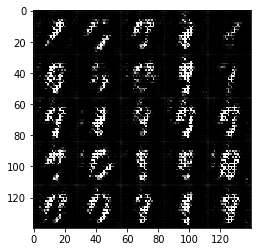

Epoch 1/2... Images processed: 3840/60000... Discriminator Loss: 1.6263... Generator Loss: 0.7092
Epoch 1/2... Images processed: 4800/60000... Discriminator Loss: 1.2702... Generator Loss: 0.6396
Epoch 1/2... Images processed: 5760/60000... Discriminator Loss: 1.8569... Generator Loss: 1.6050


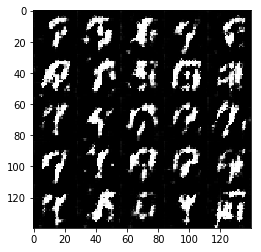

Epoch 1/2... Images processed: 6720/60000... Discriminator Loss: 0.9912... Generator Loss: 1.1640
Epoch 1/2... Images processed: 7680/60000... Discriminator Loss: 1.3767... Generator Loss: 1.4806
Epoch 1/2... Images processed: 8640/60000... Discriminator Loss: 2.3199... Generator Loss: 0.1606
Epoch 1/2... Images processed: 9600/60000... Discriminator Loss: 2.2087... Generator Loss: 0.1904


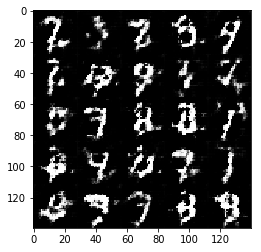

Epoch 1/2... Images processed: 10560/60000... Discriminator Loss: 1.4688... Generator Loss: 0.5962
Epoch 1/2... Images processed: 11520/60000... Discriminator Loss: 1.8435... Generator Loss: 0.2720
Epoch 1/2... Images processed: 12480/60000... Discriminator Loss: 1.1626... Generator Loss: 0.6662


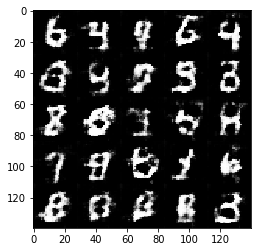

Epoch 1/2... Images processed: 13440/60000... Discriminator Loss: 1.5950... Generator Loss: 0.3709
Epoch 1/2... Images processed: 14400/60000... Discriminator Loss: 1.7352... Generator Loss: 0.3274
Epoch 1/2... Images processed: 15360/60000... Discriminator Loss: 1.2382... Generator Loss: 1.7703


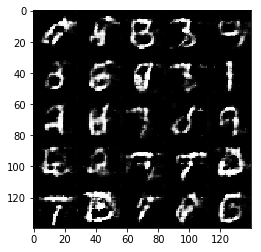

Epoch 1/2... Images processed: 16320/60000... Discriminator Loss: 0.8955... Generator Loss: 1.0114
Epoch 1/2... Images processed: 17280/60000... Discriminator Loss: 1.8512... Generator Loss: 0.2589
Epoch 1/2... Images processed: 18240/60000... Discriminator Loss: 1.3747... Generator Loss: 0.4831
Epoch 1/2... Images processed: 19200/60000... Discriminator Loss: 1.3858... Generator Loss: 0.4657


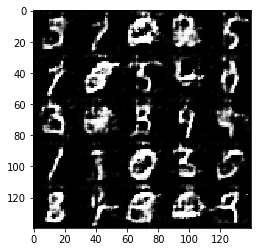

Epoch 1/2... Images processed: 20160/60000... Discriminator Loss: 1.3907... Generator Loss: 0.5765
Epoch 1/2... Images processed: 21120/60000... Discriminator Loss: 1.2044... Generator Loss: 0.7264
Epoch 1/2... Images processed: 22080/60000... Discriminator Loss: 1.1124... Generator Loss: 1.4545


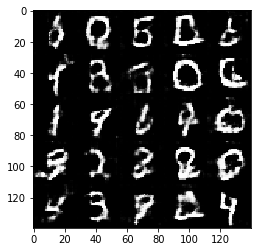

Epoch 1/2... Images processed: 23040/60000... Discriminator Loss: 0.9990... Generator Loss: 0.9009
Epoch 1/2... Images processed: 24000/60000... Discriminator Loss: 1.3787... Generator Loss: 0.4757
Epoch 1/2... Images processed: 24960/60000... Discriminator Loss: 1.2699... Generator Loss: 1.5152


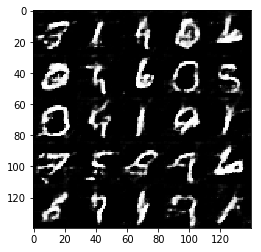

Epoch 1/2... Images processed: 25920/60000... Discriminator Loss: 1.5839... Generator Loss: 0.3864
Epoch 1/2... Images processed: 26880/60000... Discriminator Loss: 1.1633... Generator Loss: 1.9002
Epoch 1/2... Images processed: 27840/60000... Discriminator Loss: 0.9472... Generator Loss: 1.4203
Epoch 1/2... Images processed: 28800/60000... Discriminator Loss: 1.0263... Generator Loss: 0.8533


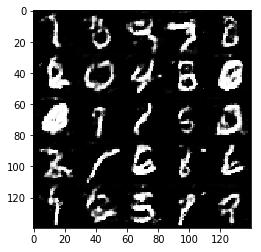

Epoch 1/2... Images processed: 29760/60000... Discriminator Loss: 1.8683... Generator Loss: 0.2794
Epoch 1/2... Images processed: 30720/60000... Discriminator Loss: 1.2546... Generator Loss: 1.1442
Epoch 1/2... Images processed: 31680/60000... Discriminator Loss: 0.9132... Generator Loss: 1.5954


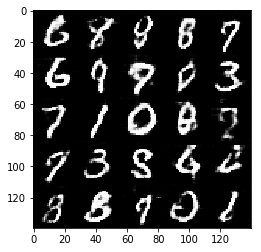

Epoch 1/2... Images processed: 32640/60000... Discriminator Loss: 2.0137... Generator Loss: 0.2292
Epoch 1/2... Images processed: 33600/60000... Discriminator Loss: 1.0889... Generator Loss: 0.8402
Epoch 1/2... Images processed: 34560/60000... Discriminator Loss: 0.9792... Generator Loss: 0.9326


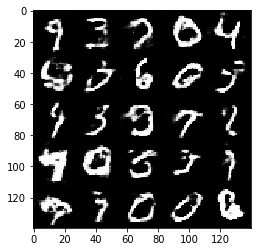

Epoch 1/2... Images processed: 35520/60000... Discriminator Loss: 0.9313... Generator Loss: 1.0746
Epoch 1/2... Images processed: 36480/60000... Discriminator Loss: 1.0220... Generator Loss: 1.3599
Epoch 1/2... Images processed: 37440/60000... Discriminator Loss: 0.8560... Generator Loss: 1.1139
Epoch 1/2... Images processed: 38400/60000... Discriminator Loss: 1.2805... Generator Loss: 0.5110


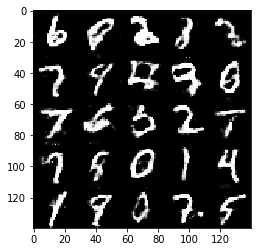

Epoch 1/2... Images processed: 39360/60000... Discriminator Loss: 1.1300... Generator Loss: 2.7142
Epoch 1/2... Images processed: 40320/60000... Discriminator Loss: 1.2923... Generator Loss: 0.5119
Epoch 1/2... Images processed: 41280/60000... Discriminator Loss: 0.8750... Generator Loss: 1.0911


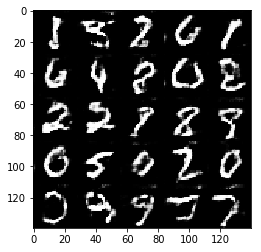

Epoch 1/2... Images processed: 42240/60000... Discriminator Loss: 1.4098... Generator Loss: 0.5552
Epoch 1/2... Images processed: 43200/60000... Discriminator Loss: 0.9328... Generator Loss: 0.8805
Epoch 1/2... Images processed: 44160/60000... Discriminator Loss: 1.4502... Generator Loss: 0.4981


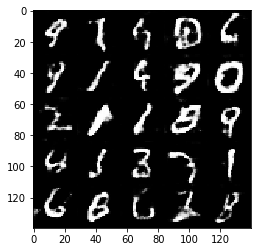

Epoch 1/2... Images processed: 45120/60000... Discriminator Loss: 1.5107... Generator Loss: 0.4520
Epoch 1/2... Images processed: 46080/60000... Discriminator Loss: 0.5873... Generator Loss: 1.5901
Epoch 1/2... Images processed: 47040/60000... Discriminator Loss: 0.7711... Generator Loss: 1.5767
Epoch 1/2... Images processed: 48000/60000... Discriminator Loss: 1.1598... Generator Loss: 0.7236


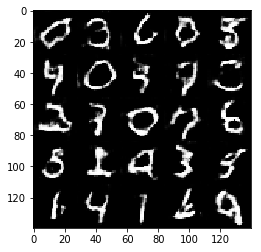

Epoch 1/2... Images processed: 48960/60000... Discriminator Loss: 1.3916... Generator Loss: 0.4692
Epoch 1/2... Images processed: 49920/60000... Discriminator Loss: 1.7595... Generator Loss: 3.0005
Epoch 1/2... Images processed: 50880/60000... Discriminator Loss: 1.9769... Generator Loss: 0.2518


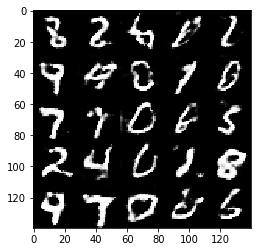

Epoch 1/2... Images processed: 51840/60000... Discriminator Loss: 0.8332... Generator Loss: 1.9761
Epoch 1/2... Images processed: 52800/60000... Discriminator Loss: 0.7762... Generator Loss: 1.2903
Epoch 1/2... Images processed: 53760/60000... Discriminator Loss: 1.9021... Generator Loss: 0.3126


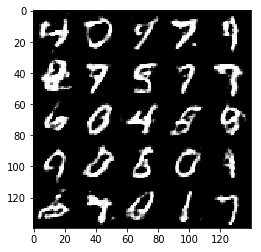

Epoch 1/2... Images processed: 54720/60000... Discriminator Loss: 0.9997... Generator Loss: 0.8662
Epoch 1/2... Images processed: 55680/60000... Discriminator Loss: 0.7858... Generator Loss: 1.3456
Epoch 1/2... Images processed: 56640/60000... Discriminator Loss: 0.9770... Generator Loss: 0.9961
Epoch 1/2... Images processed: 57600/60000... Discriminator Loss: 2.3938... Generator Loss: 0.1864


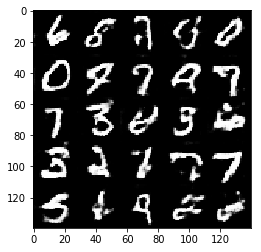

Epoch 1/2... Images processed: 58560/60000... Discriminator Loss: 1.1449... Generator Loss: 1.6229
Epoch 1/2... Images processed: 59520/60000... Discriminator Loss: 0.8935... Generator Loss: 2.2184
Epoch 2/2... Images processed: 480/60000... Discriminator Loss: 0.8008... Generator Loss: 1.0738


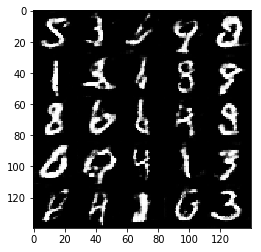

Epoch 2/2... Images processed: 1440/60000... Discriminator Loss: 0.9358... Generator Loss: 0.9088
Epoch 2/2... Images processed: 2400/60000... Discriminator Loss: 0.9893... Generator Loss: 0.8400
Epoch 2/2... Images processed: 3360/60000... Discriminator Loss: 1.1872... Generator Loss: 0.5931


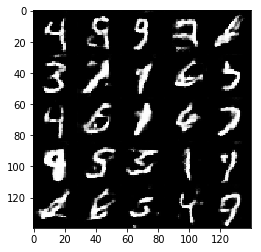

Epoch 2/2... Images processed: 4320/60000... Discriminator Loss: 0.7380... Generator Loss: 1.2195
Epoch 2/2... Images processed: 5280/60000... Discriminator Loss: 1.8843... Generator Loss: 0.5680
Epoch 2/2... Images processed: 6240/60000... Discriminator Loss: 0.6506... Generator Loss: 1.4957
Epoch 2/2... Images processed: 7200/60000... Discriminator Loss: 0.9041... Generator Loss: 0.8930


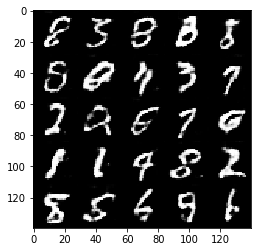

Epoch 2/2... Images processed: 8160/60000... Discriminator Loss: 0.7278... Generator Loss: 1.7038
Epoch 2/2... Images processed: 9120/60000... Discriminator Loss: 0.6188... Generator Loss: 2.0263
Epoch 2/2... Images processed: 10080/60000... Discriminator Loss: 0.6842... Generator Loss: 1.3997


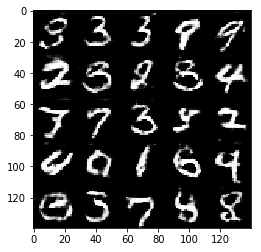

Epoch 2/2... Images processed: 11040/60000... Discriminator Loss: 0.7369... Generator Loss: 2.9404
Epoch 2/2... Images processed: 12000/60000... Discriminator Loss: 0.8086... Generator Loss: 1.2269
Epoch 2/2... Images processed: 12960/60000... Discriminator Loss: 1.3701... Generator Loss: 0.5559


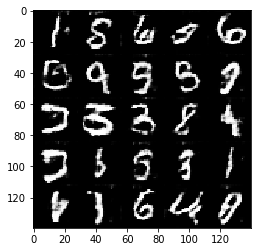

Epoch 2/2... Images processed: 13920/60000... Discriminator Loss: 0.8679... Generator Loss: 1.4211
Epoch 2/2... Images processed: 14880/60000... Discriminator Loss: 4.2962... Generator Loss: 7.0289
Epoch 2/2... Images processed: 15840/60000... Discriminator Loss: 0.5748... Generator Loss: 1.8556
Epoch 2/2... Images processed: 16800/60000... Discriminator Loss: 0.8529... Generator Loss: 1.3062


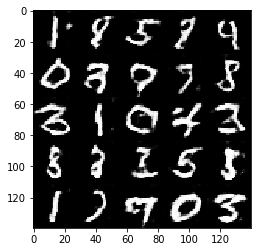

Epoch 2/2... Images processed: 17760/60000... Discriminator Loss: 0.8295... Generator Loss: 1.1803
Epoch 2/2... Images processed: 18720/60000... Discriminator Loss: 0.9595... Generator Loss: 0.9503
Epoch 2/2... Images processed: 19680/60000... Discriminator Loss: 0.4553... Generator Loss: 2.7157


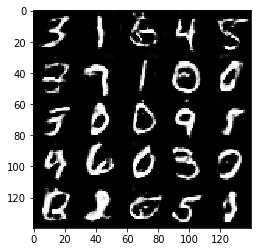

Epoch 2/2... Images processed: 20640/60000... Discriminator Loss: 1.0367... Generator Loss: 2.3195
Epoch 2/2... Images processed: 21600/60000... Discriminator Loss: 1.2476... Generator Loss: 0.6506
Epoch 2/2... Images processed: 22560/60000... Discriminator Loss: 0.8078... Generator Loss: 3.2647


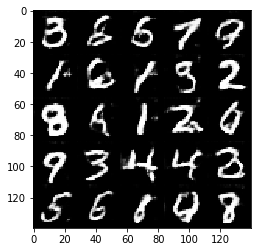

Epoch 2/2... Images processed: 23520/60000... Discriminator Loss: 0.8076... Generator Loss: 1.0933
Epoch 2/2... Images processed: 24480/60000... Discriminator Loss: 0.8008... Generator Loss: 1.1773
Epoch 2/2... Images processed: 25440/60000... Discriminator Loss: 0.6216... Generator Loss: 2.2896
Epoch 2/2... Images processed: 26400/60000... Discriminator Loss: 0.6528... Generator Loss: 1.5477


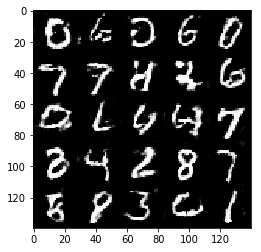

Epoch 2/2... Images processed: 27360/60000... Discriminator Loss: 1.5903... Generator Loss: 0.4702
Epoch 2/2... Images processed: 28320/60000... Discriminator Loss: 0.5671... Generator Loss: 2.2992
Epoch 2/2... Images processed: 29280/60000... Discriminator Loss: 0.6526... Generator Loss: 1.5795


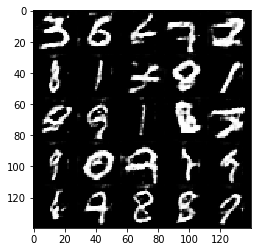

Epoch 2/2... Images processed: 30240/60000... Discriminator Loss: 1.1516... Generator Loss: 0.7067
Epoch 2/2... Images processed: 31200/60000... Discriminator Loss: 0.6638... Generator Loss: 1.6356
Epoch 2/2... Images processed: 32160/60000... Discriminator Loss: 0.5928... Generator Loss: 1.9326


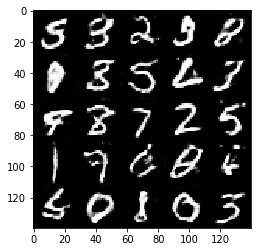

Epoch 2/2... Images processed: 33120/60000... Discriminator Loss: 0.6700... Generator Loss: 1.7324
Epoch 2/2... Images processed: 34080/60000... Discriminator Loss: 1.4937... Generator Loss: 0.6135
Epoch 2/2... Images processed: 35040/60000... Discriminator Loss: 1.2346... Generator Loss: 0.6760
Epoch 2/2... Images processed: 36000/60000... Discriminator Loss: 0.9912... Generator Loss: 0.8452


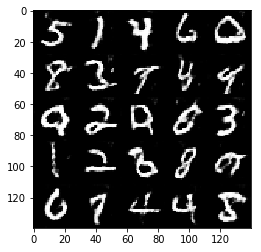

Epoch 2/2... Images processed: 36960/60000... Discriminator Loss: 0.5614... Generator Loss: 2.4236
Epoch 2/2... Images processed: 37920/60000... Discriminator Loss: 0.6650... Generator Loss: 2.3551
Epoch 2/2... Images processed: 38880/60000... Discriminator Loss: 0.7189... Generator Loss: 1.1565


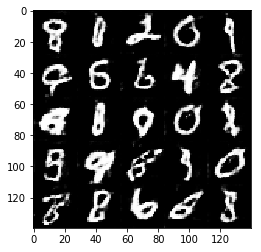

Epoch 2/2... Images processed: 39840/60000... Discriminator Loss: 0.9399... Generator Loss: 0.9991
Epoch 2/2... Images processed: 40800/60000... Discriminator Loss: 1.7912... Generator Loss: 0.4486
Epoch 2/2... Images processed: 41760/60000... Discriminator Loss: 1.9112... Generator Loss: 0.4137


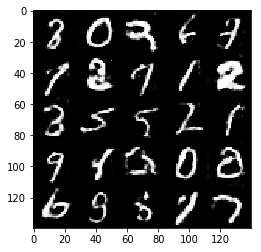

Epoch 2/2... Images processed: 42720/60000... Discriminator Loss: 1.6005... Generator Loss: 0.4792
Epoch 2/2... Images processed: 43680/60000... Discriminator Loss: 0.6578... Generator Loss: 1.9002
Epoch 2/2... Images processed: 44640/60000... Discriminator Loss: 0.5217... Generator Loss: 2.1564
Epoch 2/2... Images processed: 45600/60000... Discriminator Loss: 2.2220... Generator Loss: 0.3909


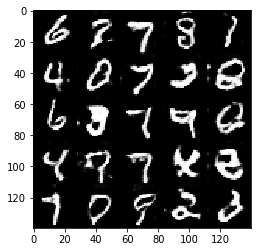

Epoch 2/2... Images processed: 46560/60000... Discriminator Loss: 1.8395... Generator Loss: 0.5815
Epoch 2/2... Images processed: 47520/60000... Discriminator Loss: 1.1052... Generator Loss: 1.0185
Epoch 2/2... Images processed: 48480/60000... Discriminator Loss: 0.8626... Generator Loss: 0.9535


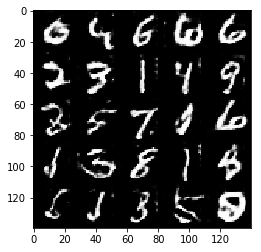

Epoch 2/2... Images processed: 49440/60000... Discriminator Loss: 0.5987... Generator Loss: 1.8630
Epoch 2/2... Images processed: 50400/60000... Discriminator Loss: 0.6936... Generator Loss: 1.5157
Epoch 2/2... Images processed: 51360/60000... Discriminator Loss: 4.1069... Generator Loss: 9.0310


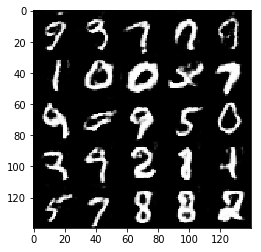

Epoch 2/2... Images processed: 52320/60000... Discriminator Loss: 0.6118... Generator Loss: 1.9983
Epoch 2/2... Images processed: 53280/60000... Discriminator Loss: 2.8398... Generator Loss: 0.1731
Epoch 2/2... Images processed: 54240/60000... Discriminator Loss: 2.9931... Generator Loss: 0.1096
Epoch 2/2... Images processed: 55200/60000... Discriminator Loss: 0.8094... Generator Loss: 1.1981


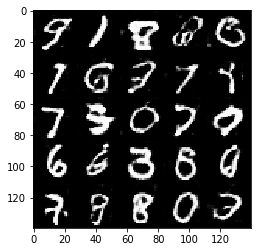

Epoch 2/2... Images processed: 56160/60000... Discriminator Loss: 0.8306... Generator Loss: 1.3045
Epoch 2/2... Images processed: 57120/60000... Discriminator Loss: 0.4681... Generator Loss: 2.5583
Epoch 2/2... Images processed: 58080/60000... Discriminator Loss: 0.9645... Generator Loss: 3.0434


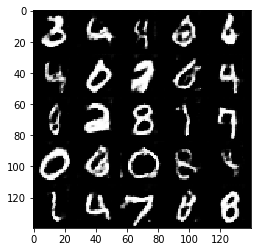

Epoch 2/2... Images processed: 59040/60000... Discriminator Loss: 0.4142... Generator Loss: 2.9358
Epoch 2/2... Images processed: 60000/60000... Discriminator Loss: 0.4864... Generator Loss: 2.3589
Final sample from generator:


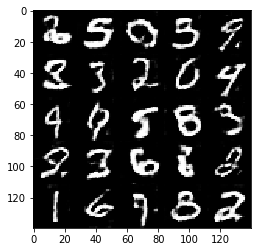

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Images processed: 960/202599... Discriminator Loss: 4.3390... Generator Loss: 0.0981
Epoch 1/1... Images processed: 1920/202599... Discriminator Loss: 3.8915... Generator Loss: 5.6505
Epoch 1/1... Images processed: 2880/202599... Discriminator Loss: 1.0300... Generator Loss: 1.7723


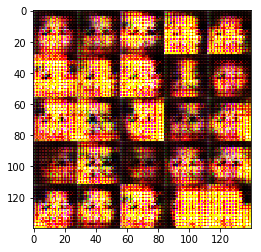

Epoch 1/1... Images processed: 3840/202599... Discriminator Loss: 0.6072... Generator Loss: 1.8271
Epoch 1/1... Images processed: 4800/202599... Discriminator Loss: 2.1121... Generator Loss: 5.5966
Epoch 1/1... Images processed: 5760/202599... Discriminator Loss: 0.6124... Generator Loss: 1.7031


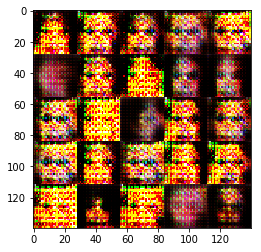

Epoch 1/1... Images processed: 6720/202599... Discriminator Loss: 5.1183... Generator Loss: 8.0699
Epoch 1/1... Images processed: 7680/202599... Discriminator Loss: 0.8711... Generator Loss: 1.0914
Epoch 1/1... Images processed: 8640/202599... Discriminator Loss: 0.5319... Generator Loss: 2.0032
Epoch 1/1... Images processed: 9600/202599... Discriminator Loss: 1.9626... Generator Loss: 0.3197


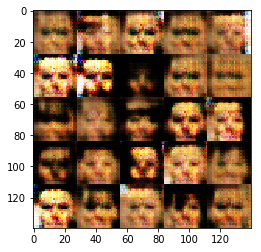

Epoch 1/1... Images processed: 10560/202599... Discriminator Loss: 0.9767... Generator Loss: 1.1160
Epoch 1/1... Images processed: 11520/202599... Discriminator Loss: 1.2423... Generator Loss: 0.5782
Epoch 1/1... Images processed: 12480/202599... Discriminator Loss: 1.5604... Generator Loss: 0.4039


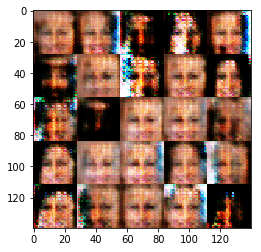

Epoch 1/1... Images processed: 13440/202599... Discriminator Loss: 0.5305... Generator Loss: 2.0199
Epoch 1/1... Images processed: 14400/202599... Discriminator Loss: 1.0075... Generator Loss: 0.7606
Epoch 1/1... Images processed: 15360/202599... Discriminator Loss: 1.3332... Generator Loss: 2.8654


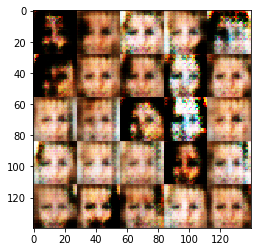

Epoch 1/1... Images processed: 16320/202599... Discriminator Loss: 1.3533... Generator Loss: 2.3969
Epoch 1/1... Images processed: 17280/202599... Discriminator Loss: 1.5722... Generator Loss: 1.8246
Epoch 1/1... Images processed: 18240/202599... Discriminator Loss: 0.7956... Generator Loss: 1.5306
Epoch 1/1... Images processed: 19200/202599... Discriminator Loss: 0.5762... Generator Loss: 1.7334


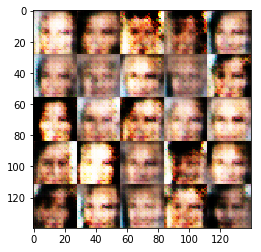

Epoch 1/1... Images processed: 20160/202599... Discriminator Loss: 0.6895... Generator Loss: 1.9689
Epoch 1/1... Images processed: 21120/202599... Discriminator Loss: 1.0346... Generator Loss: 0.8016
Epoch 1/1... Images processed: 22080/202599... Discriminator Loss: 1.3249... Generator Loss: 2.1848


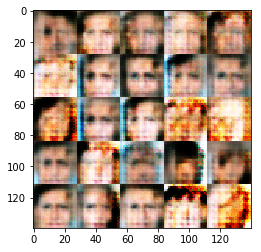

Epoch 1/1... Images processed: 23040/202599... Discriminator Loss: 1.0504... Generator Loss: 1.6447
Epoch 1/1... Images processed: 24000/202599... Discriminator Loss: 1.3322... Generator Loss: 0.6431
Epoch 1/1... Images processed: 24960/202599... Discriminator Loss: 0.9680... Generator Loss: 1.6944


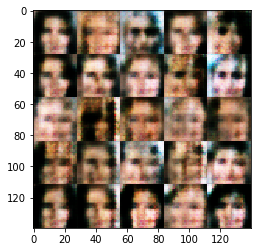

Epoch 1/1... Images processed: 25920/202599... Discriminator Loss: 1.0585... Generator Loss: 1.2889
Epoch 1/1... Images processed: 26880/202599... Discriminator Loss: 0.7777... Generator Loss: 1.1666
Epoch 1/1... Images processed: 27840/202599... Discriminator Loss: 1.1461... Generator Loss: 0.6957
Epoch 1/1... Images processed: 28800/202599... Discriminator Loss: 0.6545... Generator Loss: 2.0142


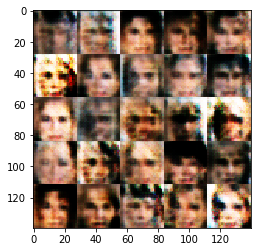

Epoch 1/1... Images processed: 29760/202599... Discriminator Loss: 1.4308... Generator Loss: 2.9575
Epoch 1/1... Images processed: 30720/202599... Discriminator Loss: 1.2059... Generator Loss: 0.6709
Epoch 1/1... Images processed: 31680/202599... Discriminator Loss: 0.9669... Generator Loss: 1.5767


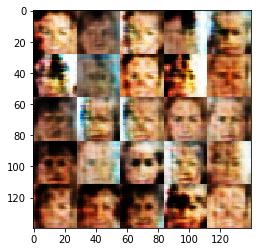

Epoch 1/1... Images processed: 32640/202599... Discriminator Loss: 0.7811... Generator Loss: 1.0648
Epoch 1/1... Images processed: 33600/202599... Discriminator Loss: 1.7486... Generator Loss: 3.2271
Epoch 1/1... Images processed: 34560/202599... Discriminator Loss: 0.6742... Generator Loss: 1.5357


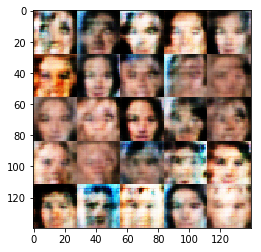

Epoch 1/1... Images processed: 35520/202599... Discriminator Loss: 1.3075... Generator Loss: 0.4991
Epoch 1/1... Images processed: 36480/202599... Discriminator Loss: 1.4405... Generator Loss: 2.3677
Epoch 1/1... Images processed: 37440/202599... Discriminator Loss: 1.2213... Generator Loss: 2.0555
Epoch 1/1... Images processed: 38400/202599... Discriminator Loss: 0.9188... Generator Loss: 0.9222


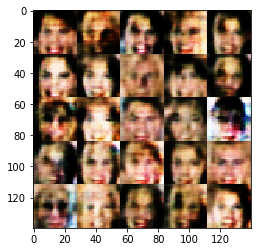

Epoch 1/1... Images processed: 39360/202599... Discriminator Loss: 1.0901... Generator Loss: 0.8085
Epoch 1/1... Images processed: 40320/202599... Discriminator Loss: 1.0795... Generator Loss: 0.9187
Epoch 1/1... Images processed: 41280/202599... Discriminator Loss: 1.2678... Generator Loss: 0.6105


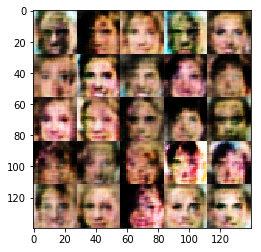

Epoch 1/1... Images processed: 42240/202599... Discriminator Loss: 0.7176... Generator Loss: 1.2469
Epoch 1/1... Images processed: 43200/202599... Discriminator Loss: 1.0896... Generator Loss: 0.6953
Epoch 1/1... Images processed: 44160/202599... Discriminator Loss: 0.8305... Generator Loss: 1.4299


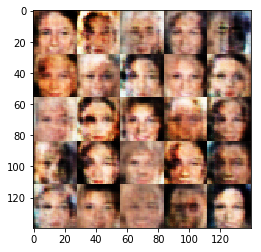

Epoch 1/1... Images processed: 45120/202599... Discriminator Loss: 1.0193... Generator Loss: 0.7296
Epoch 1/1... Images processed: 46080/202599... Discriminator Loss: 0.7221... Generator Loss: 1.4725
Epoch 1/1... Images processed: 47040/202599... Discriminator Loss: 0.7879... Generator Loss: 1.1811
Epoch 1/1... Images processed: 48000/202599... Discriminator Loss: 0.8619... Generator Loss: 1.0342


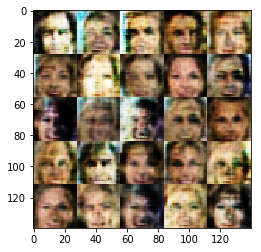

Epoch 1/1... Images processed: 48960/202599... Discriminator Loss: 0.7841... Generator Loss: 1.6148
Epoch 1/1... Images processed: 49920/202599... Discriminator Loss: 0.8023... Generator Loss: 1.6835
Epoch 1/1... Images processed: 50880/202599... Discriminator Loss: 0.8467... Generator Loss: 0.9920


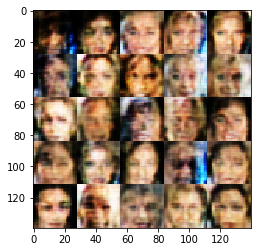

Epoch 1/1... Images processed: 51840/202599... Discriminator Loss: 1.4871... Generator Loss: 0.4163
Epoch 1/1... Images processed: 52800/202599... Discriminator Loss: 0.6524... Generator Loss: 1.4004
Epoch 1/1... Images processed: 53760/202599... Discriminator Loss: 0.5744... Generator Loss: 1.8986


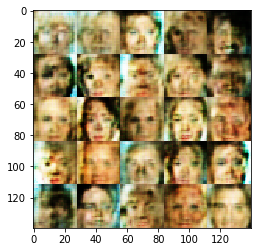

Epoch 1/1... Images processed: 54720/202599... Discriminator Loss: 0.5544... Generator Loss: 1.7544
Epoch 1/1... Images processed: 55680/202599... Discriminator Loss: 0.6862... Generator Loss: 1.3113
Epoch 1/1... Images processed: 56640/202599... Discriminator Loss: 1.4809... Generator Loss: 2.8886
Epoch 1/1... Images processed: 57600/202599... Discriminator Loss: 0.8336... Generator Loss: 1.1363


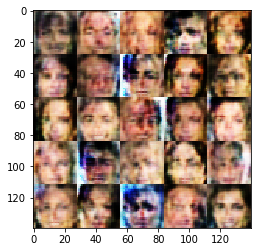

Epoch 1/1... Images processed: 58560/202599... Discriminator Loss: 0.7013... Generator Loss: 1.3837
Epoch 1/1... Images processed: 59520/202599... Discriminator Loss: 0.5752... Generator Loss: 1.8600
Epoch 1/1... Images processed: 60480/202599... Discriminator Loss: 0.5640... Generator Loss: 1.8764


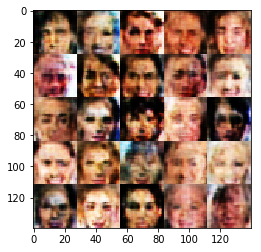

Epoch 1/1... Images processed: 61440/202599... Discriminator Loss: 0.9319... Generator Loss: 1.3224
Epoch 1/1... Images processed: 62400/202599... Discriminator Loss: 0.9934... Generator Loss: 1.8892
Epoch 1/1... Images processed: 63360/202599... Discriminator Loss: 1.3528... Generator Loss: 0.4797


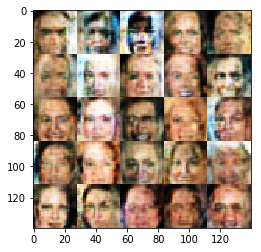

Epoch 1/1... Images processed: 64320/202599... Discriminator Loss: 1.4543... Generator Loss: 0.4864
Epoch 1/1... Images processed: 65280/202599... Discriminator Loss: 0.7651... Generator Loss: 1.0932
Epoch 1/1... Images processed: 66240/202599... Discriminator Loss: 0.6924... Generator Loss: 2.2673
Epoch 1/1... Images processed: 67200/202599... Discriminator Loss: 1.1376... Generator Loss: 1.0089


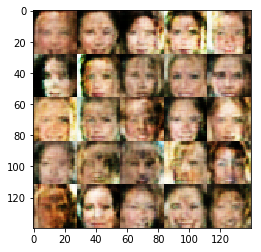

Epoch 1/1... Images processed: 68160/202599... Discriminator Loss: 1.3930... Generator Loss: 0.4345
Epoch 1/1... Images processed: 69120/202599... Discriminator Loss: 0.4884... Generator Loss: 2.0862
Epoch 1/1... Images processed: 70080/202599... Discriminator Loss: 0.3991... Generator Loss: 3.2672


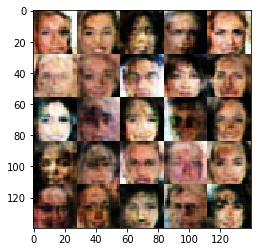

Epoch 1/1... Images processed: 71040/202599... Discriminator Loss: 0.7284... Generator Loss: 1.2385
Epoch 1/1... Images processed: 72000/202599... Discriminator Loss: 0.9144... Generator Loss: 1.3286
Epoch 1/1... Images processed: 72960/202599... Discriminator Loss: 1.0004... Generator Loss: 0.8502


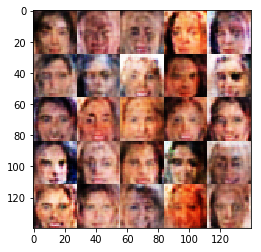

Epoch 1/1... Images processed: 73920/202599... Discriminator Loss: 0.8289... Generator Loss: 1.0330
Epoch 1/1... Images processed: 74880/202599... Discriminator Loss: 0.7983... Generator Loss: 1.1350
Epoch 1/1... Images processed: 75840/202599... Discriminator Loss: 2.3672... Generator Loss: 0.1692
Epoch 1/1... Images processed: 76800/202599... Discriminator Loss: 0.9009... Generator Loss: 1.1382


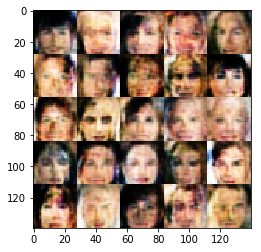

Epoch 1/1... Images processed: 77760/202599... Discriminator Loss: 0.5666... Generator Loss: 1.9535
Epoch 1/1... Images processed: 78720/202599... Discriminator Loss: 1.2768... Generator Loss: 0.5724
Epoch 1/1... Images processed: 79680/202599... Discriminator Loss: 1.0647... Generator Loss: 1.7648


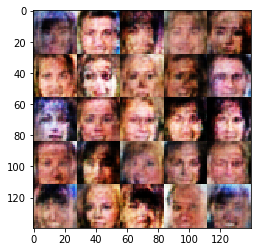

Epoch 1/1... Images processed: 80640/202599... Discriminator Loss: 1.1223... Generator Loss: 1.9272
Epoch 1/1... Images processed: 81600/202599... Discriminator Loss: 2.0679... Generator Loss: 0.2184
Epoch 1/1... Images processed: 82560/202599... Discriminator Loss: 1.0954... Generator Loss: 0.7087


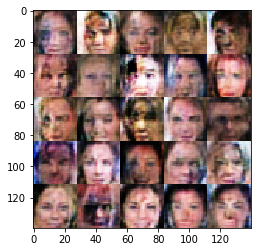

Epoch 1/1... Images processed: 83520/202599... Discriminator Loss: 0.9646... Generator Loss: 1.1560
Epoch 1/1... Images processed: 84480/202599... Discriminator Loss: 1.0523... Generator Loss: 1.8643
Epoch 1/1... Images processed: 85440/202599... Discriminator Loss: 0.7573... Generator Loss: 1.2048
Epoch 1/1... Images processed: 86400/202599... Discriminator Loss: 0.6880... Generator Loss: 1.8794


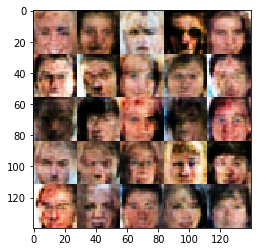

Epoch 1/1... Images processed: 87360/202599... Discriminator Loss: 1.1884... Generator Loss: 0.6808
Epoch 1/1... Images processed: 88320/202599... Discriminator Loss: 0.4063... Generator Loss: 2.6737
Epoch 1/1... Images processed: 89280/202599... Discriminator Loss: 0.5935... Generator Loss: 1.8328


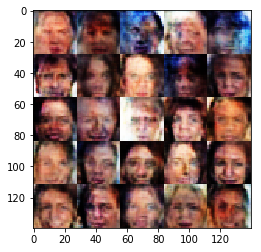

Epoch 1/1... Images processed: 90240/202599... Discriminator Loss: 1.0536... Generator Loss: 2.2422
Epoch 1/1... Images processed: 91200/202599... Discriminator Loss: 0.9969... Generator Loss: 0.9218
Epoch 1/1... Images processed: 92160/202599... Discriminator Loss: 1.2088... Generator Loss: 2.2909


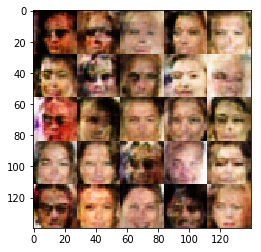

Epoch 1/1... Images processed: 93120/202599... Discriminator Loss: 0.6147... Generator Loss: 1.5294
Epoch 1/1... Images processed: 94080/202599... Discriminator Loss: 0.9941... Generator Loss: 0.7899
Epoch 1/1... Images processed: 95040/202599... Discriminator Loss: 0.5741... Generator Loss: 1.6702
Epoch 1/1... Images processed: 96000/202599... Discriminator Loss: 0.6144... Generator Loss: 2.8151


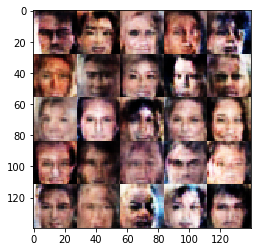

Epoch 1/1... Images processed: 96960/202599... Discriminator Loss: 2.2900... Generator Loss: 0.1655
Epoch 1/1... Images processed: 97920/202599... Discriminator Loss: 0.6316... Generator Loss: 2.1430
Epoch 1/1... Images processed: 98880/202599... Discriminator Loss: 1.4701... Generator Loss: 3.6165


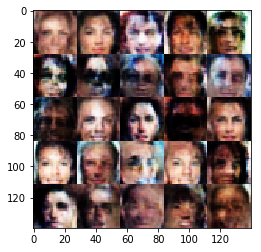

Epoch 1/1... Images processed: 99840/202599... Discriminator Loss: 0.4844... Generator Loss: 3.0731
Epoch 1/1... Images processed: 100800/202599... Discriminator Loss: 0.6613... Generator Loss: 2.2869
Epoch 1/1... Images processed: 101760/202599... Discriminator Loss: 0.5688... Generator Loss: 3.1527


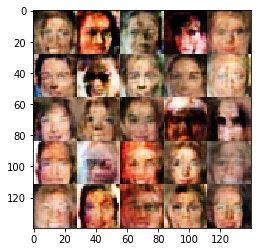

Epoch 1/1... Images processed: 102720/202599... Discriminator Loss: 0.6169... Generator Loss: 1.7444
Epoch 1/1... Images processed: 103680/202599... Discriminator Loss: 0.4370... Generator Loss: 2.6342
Epoch 1/1... Images processed: 104640/202599... Discriminator Loss: 1.0853... Generator Loss: 0.7062
Epoch 1/1... Images processed: 105600/202599... Discriminator Loss: 0.8106... Generator Loss: 2.2436


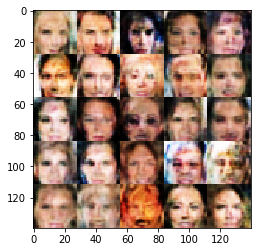

Epoch 1/1... Images processed: 106560/202599... Discriminator Loss: 0.4387... Generator Loss: 2.8310
Epoch 1/1... Images processed: 107520/202599... Discriminator Loss: 0.5447... Generator Loss: 1.8912
Epoch 1/1... Images processed: 108480/202599... Discriminator Loss: 1.6638... Generator Loss: 1.8668


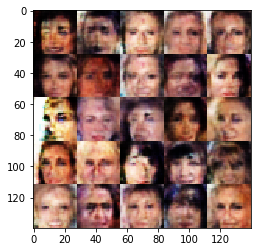

Epoch 1/1... Images processed: 109440/202599... Discriminator Loss: 0.4696... Generator Loss: 3.7652
Epoch 1/1... Images processed: 110400/202599... Discriminator Loss: 0.7424... Generator Loss: 1.1117
Epoch 1/1... Images processed: 111360/202599... Discriminator Loss: 0.5442... Generator Loss: 1.8930


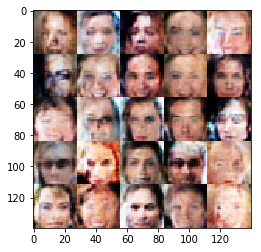

Epoch 1/1... Images processed: 112320/202599... Discriminator Loss: 0.3719... Generator Loss: 3.3601
Epoch 1/1... Images processed: 113280/202599... Discriminator Loss: 0.5439... Generator Loss: 1.9571
Epoch 1/1... Images processed: 114240/202599... Discriminator Loss: 0.8883... Generator Loss: 0.9547
Epoch 1/1... Images processed: 115200/202599... Discriminator Loss: 0.3950... Generator Loss: 3.3113


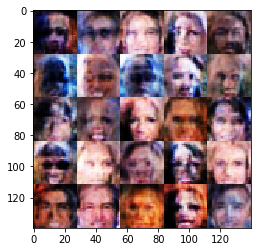

Epoch 1/1... Images processed: 116160/202599... Discriminator Loss: 0.7528... Generator Loss: 1.1389
Epoch 1/1... Images processed: 117120/202599... Discriminator Loss: 0.4788... Generator Loss: 3.0630
Epoch 1/1... Images processed: 118080/202599... Discriminator Loss: 0.4929... Generator Loss: 2.0769


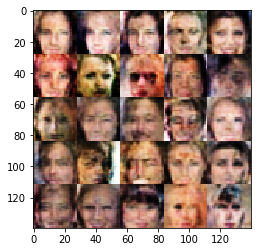

Epoch 1/1... Images processed: 119040/202599... Discriminator Loss: 1.9119... Generator Loss: 0.3010
Epoch 1/1... Images processed: 120000/202599... Discriminator Loss: 0.8552... Generator Loss: 0.9659
Epoch 1/1... Images processed: 120960/202599... Discriminator Loss: 0.8231... Generator Loss: 3.6535


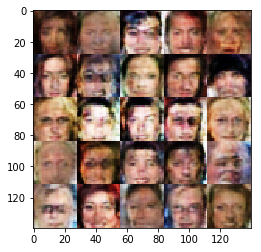

Epoch 1/1... Images processed: 121920/202599... Discriminator Loss: 0.4198... Generator Loss: 2.8629
Epoch 1/1... Images processed: 122880/202599... Discriminator Loss: 1.3698... Generator Loss: 2.2982
Epoch 1/1... Images processed: 123840/202599... Discriminator Loss: 0.9305... Generator Loss: 0.9749
Epoch 1/1... Images processed: 124800/202599... Discriminator Loss: 1.3963... Generator Loss: 0.4639


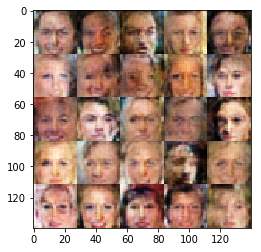

Epoch 1/1... Images processed: 125760/202599... Discriminator Loss: 0.5544... Generator Loss: 1.9590
Epoch 1/1... Images processed: 126720/202599... Discriminator Loss: 0.5991... Generator Loss: 1.8522
Epoch 1/1... Images processed: 127680/202599... Discriminator Loss: 1.0960... Generator Loss: 0.6803


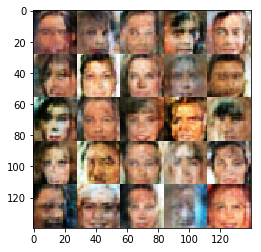

Epoch 1/1... Images processed: 128640/202599... Discriminator Loss: 0.8502... Generator Loss: 2.6058
Epoch 1/1... Images processed: 129600/202599... Discriminator Loss: 0.4568... Generator Loss: 2.2320
Epoch 1/1... Images processed: 130560/202599... Discriminator Loss: 0.9366... Generator Loss: 0.8513


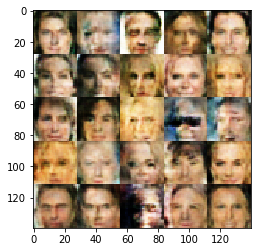

Epoch 1/1... Images processed: 131520/202599... Discriminator Loss: 0.5711... Generator Loss: 1.7762
Epoch 1/1... Images processed: 132480/202599... Discriminator Loss: 0.7731... Generator Loss: 1.5393
Epoch 1/1... Images processed: 133440/202599... Discriminator Loss: 0.7381... Generator Loss: 1.5374
Epoch 1/1... Images processed: 134400/202599... Discriminator Loss: 1.3976... Generator Loss: 0.7253


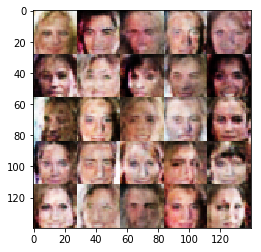

Epoch 1/1... Images processed: 135360/202599... Discriminator Loss: 1.0834... Generator Loss: 0.7468
Epoch 1/1... Images processed: 136320/202599... Discriminator Loss: 2.4506... Generator Loss: 4.1902
Epoch 1/1... Images processed: 137280/202599... Discriminator Loss: 0.8967... Generator Loss: 0.9008


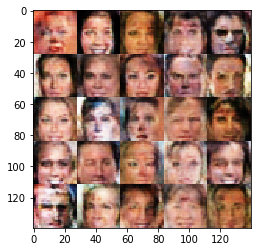

Epoch 1/1... Images processed: 138240/202599... Discriminator Loss: 1.0970... Generator Loss: 0.6978
Epoch 1/1... Images processed: 139200/202599... Discriminator Loss: 2.4660... Generator Loss: 0.1478
Epoch 1/1... Images processed: 140160/202599... Discriminator Loss: 0.7359... Generator Loss: 1.2985


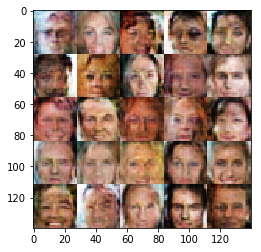

Epoch 1/1... Images processed: 141120/202599... Discriminator Loss: 0.4470... Generator Loss: 2.4552
Epoch 1/1... Images processed: 142080/202599... Discriminator Loss: 0.5718... Generator Loss: 1.7238
Epoch 1/1... Images processed: 143040/202599... Discriminator Loss: 0.4370... Generator Loss: 2.7008
Epoch 1/1... Images processed: 144000/202599... Discriminator Loss: 0.9177... Generator Loss: 1.0431


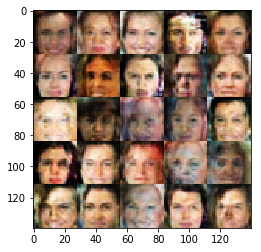

Epoch 1/1... Images processed: 144960/202599... Discriminator Loss: 1.3227... Generator Loss: 0.5129
Epoch 1/1... Images processed: 145920/202599... Discriminator Loss: 1.0956... Generator Loss: 0.6973
Epoch 1/1... Images processed: 146880/202599... Discriminator Loss: 0.6238... Generator Loss: 1.5041


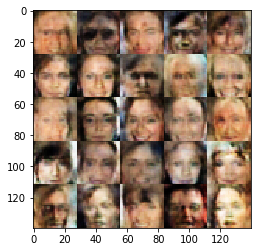

Epoch 1/1... Images processed: 147840/202599... Discriminator Loss: 1.5375... Generator Loss: 0.4580
Epoch 1/1... Images processed: 148800/202599... Discriminator Loss: 0.5243... Generator Loss: 1.7797
Epoch 1/1... Images processed: 149760/202599... Discriminator Loss: 0.5665... Generator Loss: 1.8833


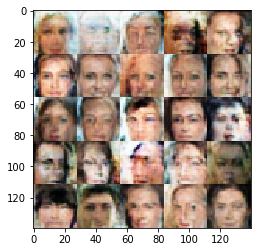

Epoch 1/1... Images processed: 150720/202599... Discriminator Loss: 0.3997... Generator Loss: 4.0184
Epoch 1/1... Images processed: 151680/202599... Discriminator Loss: 0.9186... Generator Loss: 1.0255
Epoch 1/1... Images processed: 152640/202599... Discriminator Loss: 0.7853... Generator Loss: 1.1212
Epoch 1/1... Images processed: 153600/202599... Discriminator Loss: 2.3882... Generator Loss: 0.1685


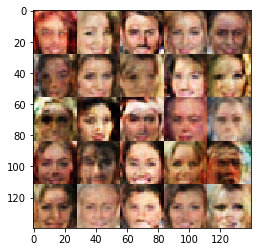

Epoch 1/1... Images processed: 154560/202599... Discriminator Loss: 0.8587... Generator Loss: 0.9577
Epoch 1/1... Images processed: 155520/202599... Discriminator Loss: 2.3897... Generator Loss: 4.2210
Epoch 1/1... Images processed: 156480/202599... Discriminator Loss: 0.4475... Generator Loss: 2.7886


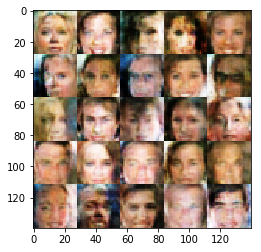

Epoch 1/1... Images processed: 157440/202599... Discriminator Loss: 0.9506... Generator Loss: 3.2284
Epoch 1/1... Images processed: 158400/202599... Discriminator Loss: 0.9870... Generator Loss: 0.8387
Epoch 1/1... Images processed: 159360/202599... Discriminator Loss: 0.7952... Generator Loss: 1.1861


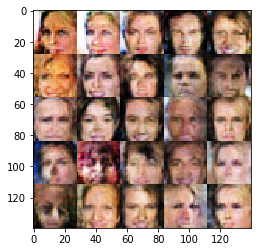

Epoch 1/1... Images processed: 160320/202599... Discriminator Loss: 0.9158... Generator Loss: 0.9050
Epoch 1/1... Images processed: 161280/202599... Discriminator Loss: 0.4657... Generator Loss: 2.4107
Epoch 1/1... Images processed: 162240/202599... Discriminator Loss: 0.5043... Generator Loss: 1.8815
Epoch 1/1... Images processed: 163200/202599... Discriminator Loss: 1.0939... Generator Loss: 2.2024


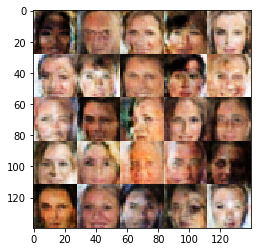

Epoch 1/1... Images processed: 164160/202599... Discriminator Loss: 1.5743... Generator Loss: 3.7665
Epoch 1/1... Images processed: 165120/202599... Discriminator Loss: 0.5540... Generator Loss: 2.6587
Epoch 1/1... Images processed: 166080/202599... Discriminator Loss: 0.8647... Generator Loss: 0.9727


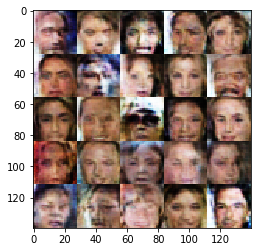

Epoch 1/1... Images processed: 167040/202599... Discriminator Loss: 0.4826... Generator Loss: 2.4661
Epoch 1/1... Images processed: 168000/202599... Discriminator Loss: 1.0525... Generator Loss: 0.7588
Epoch 1/1... Images processed: 168960/202599... Discriminator Loss: 0.7662... Generator Loss: 2.6280


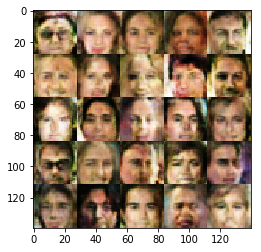

Epoch 1/1... Images processed: 169920/202599... Discriminator Loss: 0.9667... Generator Loss: 3.1661
Epoch 1/1... Images processed: 170880/202599... Discriminator Loss: 0.4241... Generator Loss: 3.4592
Epoch 1/1... Images processed: 171840/202599... Discriminator Loss: 1.0501... Generator Loss: 0.7366
Epoch 1/1... Images processed: 172800/202599... Discriminator Loss: 0.4693... Generator Loss: 2.3390


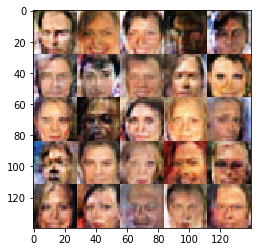

Epoch 1/1... Images processed: 173760/202599... Discriminator Loss: 0.7393... Generator Loss: 1.4638
Epoch 1/1... Images processed: 174720/202599... Discriminator Loss: 0.5372... Generator Loss: 4.4212
Epoch 1/1... Images processed: 175680/202599... Discriminator Loss: 0.4570... Generator Loss: 2.7315


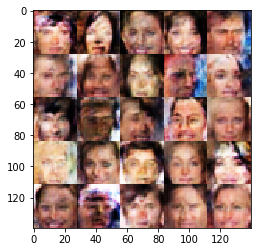

Epoch 1/1... Images processed: 176640/202599... Discriminator Loss: 0.8493... Generator Loss: 1.5444
Epoch 1/1... Images processed: 177600/202599... Discriminator Loss: 1.7511... Generator Loss: 0.3381
Epoch 1/1... Images processed: 178560/202599... Discriminator Loss: 0.4497... Generator Loss: 2.6164


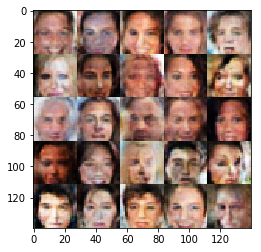

Epoch 1/1... Images processed: 179520/202599... Discriminator Loss: 0.4877... Generator Loss: 2.2990
Epoch 1/1... Images processed: 180480/202599... Discriminator Loss: 0.3863... Generator Loss: 4.1167
Epoch 1/1... Images processed: 181440/202599... Discriminator Loss: 1.0276... Generator Loss: 0.9087
Epoch 1/1... Images processed: 182400/202599... Discriminator Loss: 0.4063... Generator Loss: 3.2970


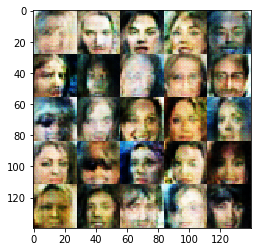

Epoch 1/1... Images processed: 183360/202599... Discriminator Loss: 0.8196... Generator Loss: 3.4453
Epoch 1/1... Images processed: 184320/202599... Discriminator Loss: 0.3875... Generator Loss: 3.4842
Epoch 1/1... Images processed: 185280/202599... Discriminator Loss: 0.7718... Generator Loss: 5.5520


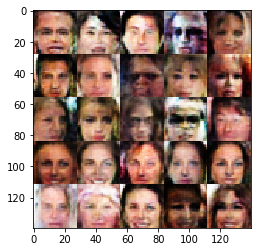

Epoch 1/1... Images processed: 186240/202599... Discriminator Loss: 0.7012... Generator Loss: 4.3645
Epoch 1/1... Images processed: 187200/202599... Discriminator Loss: 0.8292... Generator Loss: 1.6238
Epoch 1/1... Images processed: 188160/202599... Discriminator Loss: 0.6192... Generator Loss: 1.8675


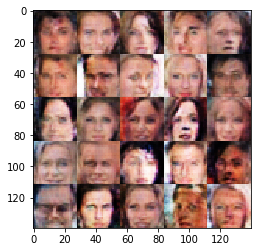

Epoch 1/1... Images processed: 189120/202599... Discriminator Loss: 0.7695... Generator Loss: 1.1769
Epoch 1/1... Images processed: 190080/202599... Discriminator Loss: 1.1496... Generator Loss: 0.6914
Epoch 1/1... Images processed: 191040/202599... Discriminator Loss: 1.0874... Generator Loss: 3.4316
Epoch 1/1... Images processed: 192000/202599... Discriminator Loss: 0.4537... Generator Loss: 2.5774


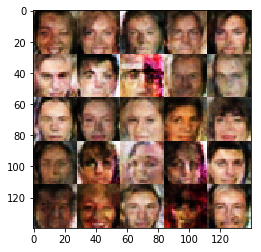

Epoch 1/1... Images processed: 192960/202599... Discriminator Loss: 0.9295... Generator Loss: 3.4594
Epoch 1/1... Images processed: 193920/202599... Discriminator Loss: 0.6045... Generator Loss: 1.9970
Epoch 1/1... Images processed: 194880/202599... Discriminator Loss: 0.5225... Generator Loss: 2.1270


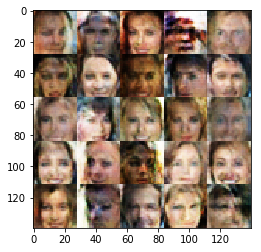

Epoch 1/1... Images processed: 195840/202599... Discriminator Loss: 0.9403... Generator Loss: 2.6833
Epoch 1/1... Images processed: 196800/202599... Discriminator Loss: 0.8930... Generator Loss: 2.7513
Epoch 1/1... Images processed: 197760/202599... Discriminator Loss: 0.9761... Generator Loss: 0.9607


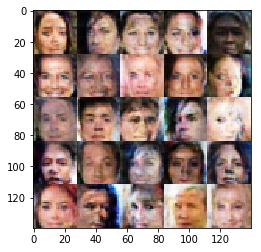

Epoch 1/1... Images processed: 198720/202599... Discriminator Loss: 0.5243... Generator Loss: 2.6477
Epoch 1/1... Images processed: 199680/202599... Discriminator Loss: 2.2798... Generator Loss: 3.1301
Epoch 1/1... Images processed: 200640/202599... Discriminator Loss: 0.8867... Generator Loss: 1.0342
Epoch 1/1... Images processed: 201600/202599... Discriminator Loss: 1.4553... Generator Loss: 0.5178


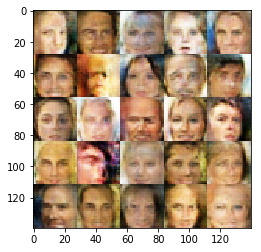

Epoch 1/1... Images processed: 202560/202599... Discriminator Loss: 1.0366... Generator Loss: 0.8158
Final sample from generator:


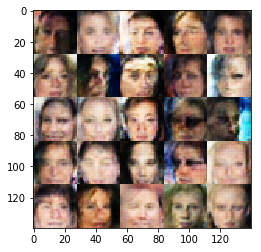

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.